# Entanglement within the two registers

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.aer.library import SaveDensityMatrix
from qiskit.visualization import array_to_latex
import qiskit.quantum_info as qi
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from qiskit import execute, transpile, assemble
from qiskit import Aer
from qiskit.visualization import plot_histogram
from sympy import factorint
from numpy import linalg
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
from sympy import *
import random
from random import sample
import math

In [3]:
def check(number):
    if number % 2 == 0:
        print("Even, 2 is a divisor")
        return
        
    if isprime(number) == True:
        print("Prime number")
        return
    
    factorization = factorint(number)
    for i in range(len(factorization.keys())):
        p = list(factorization)[i]
        q = list(factorization.values())[i]
        if isprime(p) and q != 1:
            print("Prime Power: %i^%i, %i is a divisor" % ( p, q, p))
            return
    
    y = random.randrange(2, number - 1)
    a = math.gcd(y, number)
    if a > 1:
        print("Divisor: a = %i" %(a))
        return y
        
    else:
        print("y = %i and N = %i are coprime - r well defined" %  (y, N))
        return 

In [4]:
def mod_exp(n, y, N, power):
    dim = 2**n
    matrix = np.zeros((dim, dim))
    
    for i in range(N):
        j = (i*y)%N
        matrix[j][i]=1
             
    for ii in range(N, dim):
        matrix[ii][ii] = 1
             
    matrix = linalg.matrix_power(matrix, 2**power) 
        
    U = UnitaryGate(matrix)
    
    U.name = "%i^%i mod %i" % ( y, 2**power, N)
    c_U = U.control()
    return c_U

In [5]:
def qft_dagger(n):
    qc = QuantumCircuit(n)

    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [6]:
y = 2  
N = 15 

runs = 1
#partition = 7

n = math.ceil(math.log(N,2))
control = QuantumRegister(2*n, 'r1')
target  = QuantumRegister(n, 't1')
classic = ClassicalRegister(2*n, 'c')

rho_step = 12 
somma = np.zeros(rho_step)

for j in range(runs):
    circuit = QuantumCircuit(control, target, classic)
    partition = random.randint(1, 2*n)
    qubits = random.sample(range(0, 2*n), partition)
    print(qubits)

    size = len(qubits)
    label = 0
    circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
    circuit.barrier(3*n - 1)
    circuit.h(range(2*n))
    circuit.x(2*n + n -1)
    label += 1
    circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])

    for q in range(2*n):
        label += 1
        circuit.append(mod_exp(n, y, N, q), [q] + [i+2*n for i in range(n)]) 
        circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
        
    circuit.append(qft_dagger(2*n), range(2*n)) 
    label += 1
    circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])

    circuit.measure(control, classic)
    label += 1
    circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])

    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(circuit, aer_sim)
    qobj = assemble(t_qc)
    results = aer_sim.run(qobj, shots = 1).result()
    counts = results.get_counts()

    labels = []
    for i in range(len(counts)):
        labels.append(int(list(counts.keys())[i], 2))

    negativities = []
    for i in range(rho_step):
        density_matrix = results.data()['pho_%.1f' % (i)]
        #conjugate = density_matrix.transpose()#_op
        #product = np.matmul(conjugate, density_matrix) #_op
        #root = np.sqrt(product)
        #norm = root.trace()
        #negativities.append((norm- 1)/2)
        negativities.append(qi.entropy(density_matrix))        
        #density_matrix_op = density_matrix.to_operator()
        #density_matrix_tr = density_matrix_op.transpose()
        #negativities.append( linalg.norm(density_matrix_tr, 1) - 1 )
        
    print(j, negativities)
    for i in range(len(negativities)):
        somma[i] = somma[i] + negativities[i]

    negativities = 0
    counts = 0
    results = 0
    density_matrix = 0
    circuit = 0
    t_qc = 0
    qobj = 0
    j += 1

[5, 4, 1, 2, 0]
0 [0.0, 5.544388994727084e-16, 0.9999999999999302, 2.000000000000181, 2.000000000000181, 2.000000000000181, 2.000000000000181, 2.000000000000181, 2.000000000000181, 2.000000000000181, 1.753709652981076e-30, 0.0]


In [7]:
media = np.zeros(rho_step)
for i in range(rho_step):
    media[i] =  somma[i]/ runs

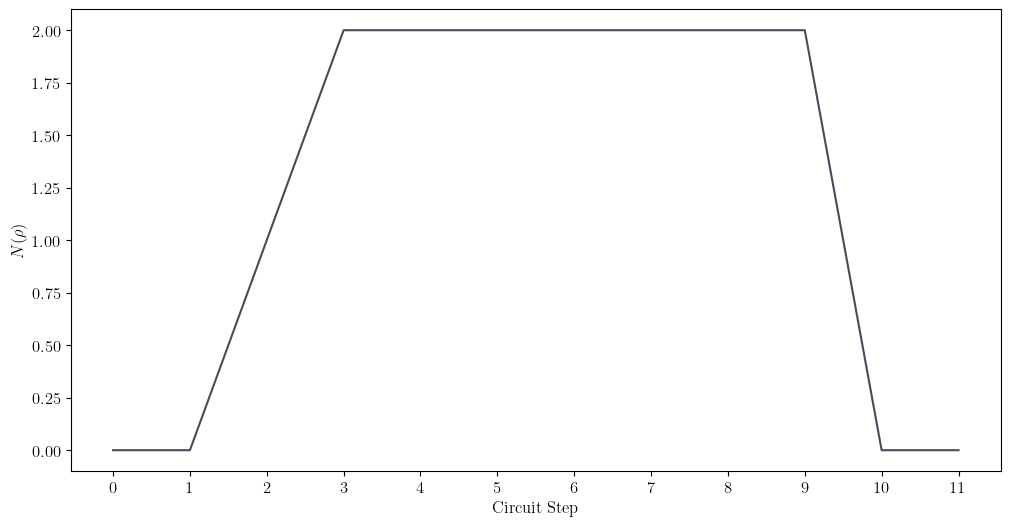

In [8]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 6))
params = {'text.usetex' : True, 'font.size' : 12, 'font.family' : 'serif'}
plt.rcParams.update(params)

xs = []
for i in range(len(media)):
    xs.append(i)

plt.xticks(xs)
plt.xlabel('Circuit Step')
plt.ylabel(r"$N(\rho)$")
plt.plot(media, color = '#4C495A')
#plt.savefig('shor_ent_within.pdf', format = 'pdf')


In [ ]:
media

array([0. , 0. , 1. , 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5])